# Student Perfomance

### Importing Data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neural_network import MLPRegressor

# Load Datasets
math = pd.read_csv("student/student-mat.csv", sep=";")
por = pd.read_csv("student/student-por.csv", sep=";")

# Understanding the data
print("=== Basic Dataset Information ===")
print(f"Math Dataset Shape: {math.head}")
print(f"Portuguese Dataset Shape: {por.head}")

print("=== Checking for Missing Values ===")
print("Missing Values in Math Dataset:")
print(math.isnull().sum(), "\n")

print("Missing Values in Portuguese Dataset:")
print(por.isnull().sum(), "\n")

# Merge Datasets
merge_columns = ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 
                 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 
                 'nursery', 'internet']

merged_df = pd.merge(math, por, on=merge_columns, suffixes=('_math', '_port'))

# Understanding the data
print("=== Basic Dataset Information ===")
print(f"Merged Dataset Shape: {merged_df.shape}")
print("\nMerged Dataset Columns:")
print(merged_df.columns.tolist())

print("\n=== First Few Rows of the Merged Dataset ===")
print(merged_df.head())

print("\n=== Data Types and Missing Values ===")
print(merged_df.info())

print("\n=== Summary Statistics ===")
print(merged_df.describe())

=== Basic Dataset Information ===
Math Dataset Shape: <bound method NDFrame.head of     school sex  age address famsize Pstatus  Medu  Fedu      Mjob      Fjob  \
0       GP   F   18       U     GT3       A     4     4   at_home   teacher   
1       GP   F   17       U     GT3       T     1     1   at_home     other   
2       GP   F   15       U     LE3       T     1     1   at_home     other   
3       GP   F   15       U     GT3       T     4     2    health  services   
4       GP   F   16       U     GT3       T     3     3     other     other   
..     ...  ..  ...     ...     ...     ...   ...   ...       ...       ...   
390     MS   M   20       U     LE3       A     2     2  services  services   
391     MS   M   17       U     LE3       T     3     1  services  services   
392     MS   M   21       R     GT3       T     1     1     other     other   
393     MS   M   18       R     LE3       T     3     2  services     other   
394     MS   M   19       U     LE3       T    

### Data Preprocessing

In [2]:
# Handle Binary Categorical Columns
binary_categorical_columns = [
    'schoolsup', 'famsup', 'paid', 'activities', 'higher', 'romantic'
]
for col in binary_categorical_columns:
    col_math = f'{col}_math'
    col_port = f'{col}_port'
    if col_math in merged_df.columns and col_port in merged_df.columns:
        merged_df[col] = merged_df[col_math].where(merged_df[col_math] == merged_df[col_port], merged_df[col_math])
        merged_df.drop([col_math, col_port], axis=1, inplace=True)

# Handle Numeric Columns
numeric_columns = ['traveltime', 'studytime', 'failures', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']
for col in numeric_columns:
    math_col = f"{col}_math"
    port_col = f"{col}_port"
    if math_col in merged_df.columns and port_col in merged_df.columns:
        merged_df[col] = merged_df[[math_col, port_col]].mean(axis=1)
        merged_df.drop([math_col, port_col], axis=1, inplace=True)

# Handle Ordinal Categorical Columns
ordinal_categorical_columns = ['famrel', 'freetime', 'goout']
for col in ordinal_categorical_columns:
    col_math = f'{col}_math'
    col_port = f'{col}_port'
    if col_math in merged_df.columns and col_port in merged_df.columns:
        merged_df[col] = merged_df[col_math].where(merged_df[col_math] == merged_df[col_port], merged_df[col_math])
        merged_df.drop([col_math, col_port], axis=1, inplace=True)

# Apply One-Hot Encoding
categorical_columns = merged_df.select_dtypes(include=['object']).columns.tolist()
merged_df_encoded = pd.get_dummies(merged_df, columns=categorical_columns, drop_first=True)

# Calculate the correlation matrix
correlation_matrix = merged_df_encoded.corr()

# Extract correlations involving the target variable G3
g3_correlation = correlation_matrix['G3'].sort_values(ascending=False)

# Print the correlation values
print("Correlation with G3:")
print(g3_correlation)

# Standardize numeric columns
scaler = StandardScaler()
numeric_columns = merged_df_encoded.select_dtypes(include=['number']).columns.tolist()
merged_df_encoded[numeric_columns] = scaler.fit_transform(merged_df_encoded[numeric_columns])

# Separate target (G3) from features
X = merged_df_encoded.drop(columns=['G3'])
y = merged_df_encoded['G3']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Correlation with G3:
G3                   1.000000
G2                   0.933571
G1                   0.872375
higher_yes           0.293610
Medu                 0.247265
Fedu                 0.198398
studytime            0.181763
address_U            0.152525
reason_reputation    0.135818
Mjob_health          0.129949
paid_yes             0.112868
Fjob_teacher         0.105726
internet_yes         0.104276
Mjob_teacher         0.098307
famsize_LE3          0.095941
Mjob_services        0.081706
activities_yes       0.071303
nursery_yes          0.065024
famrel               0.061613
Fjob_health          0.048890
guardian_mother      0.023598
famsup_yes           0.006987
sex_M                0.000206
reason_home         -0.011711
Fjob_services       -0.012708
reason_other        -0.021684
freetime            -0.036801
Fjob_other          -0.072367
Pstatus_T           -0.073135
absences            -0.094863
guardian_other      -0.101201
romantic_yes        -0.109899
schoolsup_yes      

### Modeling

In [3]:
# Initialize models
models = {
    "Ridge Regression": Ridge(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Train and evaluate models with different cross-validation splits
results = []
for name, model in models.items():
    best_cv_score = float('inf')  # Initialize with a very high value
    best_cv = 0  # To store the best CV value
    best_model = None  # To store the model trained with the best CV
    
    for cv in range(3, 11):
        cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
        mse_cv = -cv_scores.mean()  # Convert negative MSE to positive
        
        # If the current CV value has the best performance, update best_cv_score
        if mse_cv < best_cv_score:
            best_cv_score = mse_cv
            best_cv = cv
            best_model = model
    
    # Fit the model with the best CV
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Store results
    results.append({
        "Model": name, 
        "Best CV (Splits)": best_cv, 
        "MSE (CV)": best_cv_score, 
        "MSE (Test)": mse, 
        "MAE": mae, 
        "R2": r2
    })

    # Print results for the current model
    print(f"{name} Performance with Best CV ({best_cv} splits):")
    print(f"Cross-Validated MSE: {best_cv_score:.4f}")
    print(f"Test MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R2 Score: {r2:.4f}")
    print("-" * 50)

Ridge Regression Performance with Best CV (6 splits):
Cross-Validated MSE: 0.1562
Test MSE: 0.1181
MAE: 0.2564
R2 Score: 0.8895
--------------------------------------------------
Decision Tree Performance with Best CV (3 splits):
Cross-Validated MSE: 0.2124
Test MSE: 0.2433
MAE: 0.3163
R2 Score: 0.7724
--------------------------------------------------
Random Forest Performance with Best CV (4 splits):
Cross-Validated MSE: 0.1366
Test MSE: 0.1086
MAE: 0.2373
R2 Score: 0.8983
--------------------------------------------------
Gradient Boosting Performance with Best CV (7 splits):
Cross-Validated MSE: 0.1488
Test MSE: 0.1334
MAE: 0.2461
R2 Score: 0.8752
--------------------------------------------------


### Visualizations

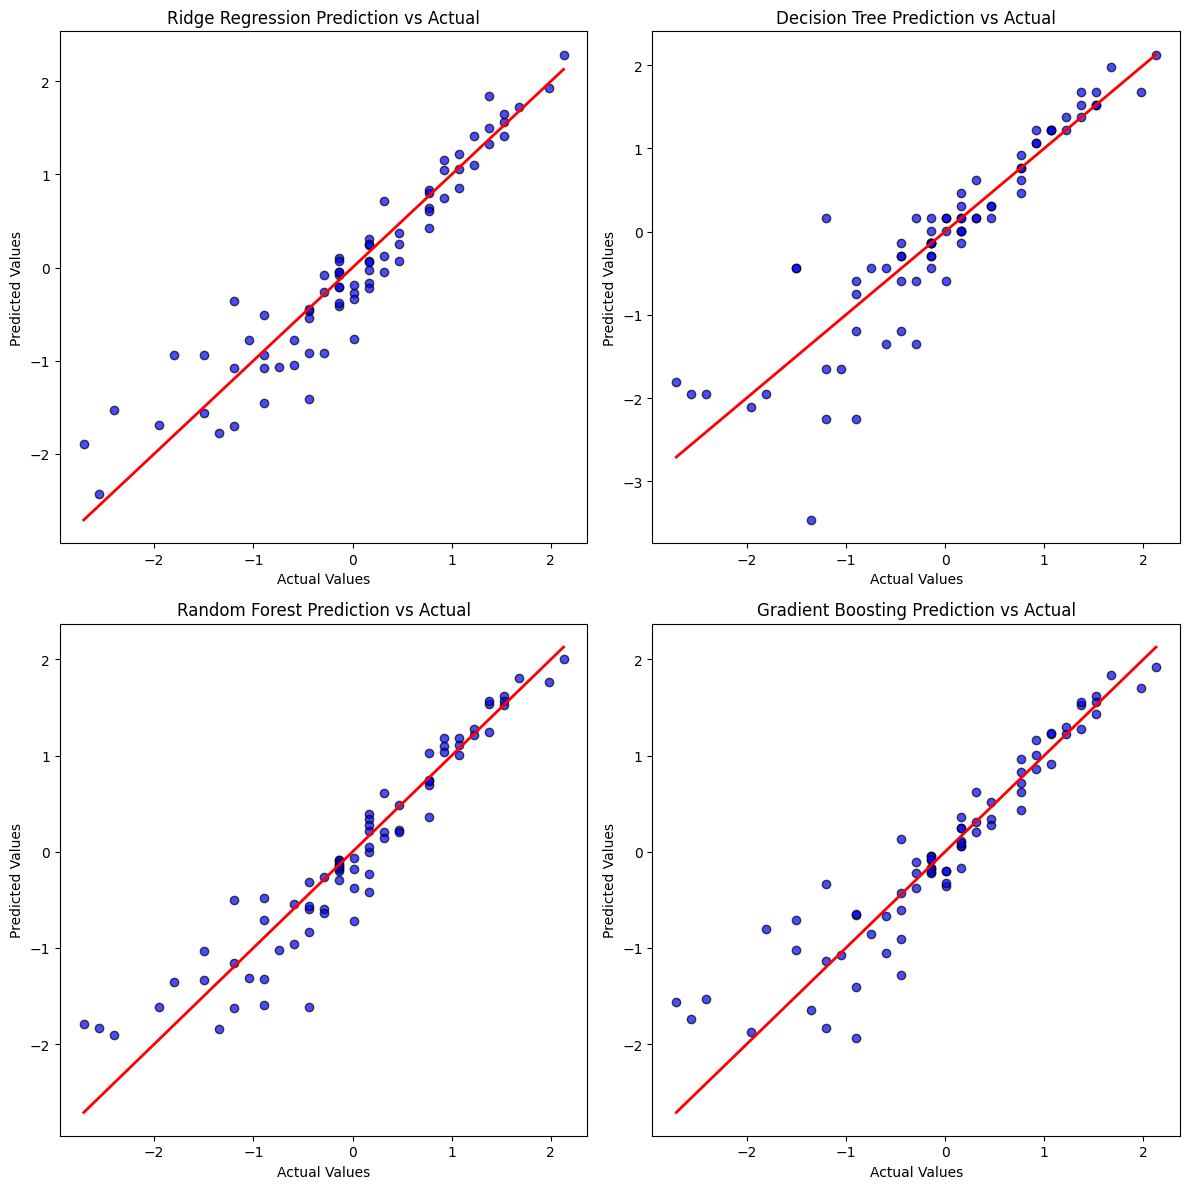

In [4]:
# Create a subplot grid
plt.figure(figsize=(12, 12))

# Loop through models to generate the plots
for i, (name, model) in enumerate(models.items(), 1):
    model.fit(X_train, y_train)  # Fit the model
    y_pred = model.predict(X_test)  # Get predictions

    plt.subplot(2, 2, i)  # Create 2x2 grid of plots
    plt.scatter(y_test, y_pred, color='blue', edgecolors='black', alpha=0.7)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'{name} Prediction vs Actual')

plt.tight_layout()
plt.show()

### Model Tuning

In [5]:
# Define the parameter grids for each model
param_grid = {
    "Ridge Regression": {
        "alpha": [0.1, 1, 10, 100]
    },
    "Decision Tree": {
        "max_depth": [3, 5, 7, 10],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4]
    },
    "Random Forest": {
        "n_estimators": [50, 100, 200],
        "max_depth": [3, 5, 10],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4]
    },
    "Gradient Boosting": {
        "n_estimators": [50, 100, 200],
        "max_depth": [3, 5, 7],
        "learning_rate": [0.01, 0.05, 0.1],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4]
    }
}

# Initialize models
models = {
    "Ridge Regression": Ridge(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Perform Hyperparameter Tuning using the best CV splits (from previous output)
best_cv_splits = {
    "Ridge Regression": 6,
    "Decision Tree": 3,
    "Random Forest": 4,
    "Gradient Boosting": 7
}

# Perform GridSearchCV for each model using the best CV splits
for model_name, model in models.items():
    print(f"Tuning {model_name}...")
    
    # Set the parameter grid for the current model
    grid_search = GridSearchCV(
        estimator=model, 
        param_grid=param_grid[model_name], 
        cv=best_cv_splits[model_name], 
        scoring='neg_mean_squared_error', 
        n_jobs=-1
    )
    
    # Fit the grid search
    grid_search.fit(X_train, y_train)
    
    # Get the best parameters and best score
    best_params = grid_search.best_params_
    best_score = -grid_search.best_score_  # Convert negative MSE back to positive

    # Print the best parameters and score
    print(f"Best Parameters for {model_name}: {best_params}")
    print(f"Best Cross-Validated MSE: {best_score:.4f}")
    
    # Use the best model found by GridSearchCV
    best_model = grid_search.best_estimator_
    
    # Make predictions using the best model
    y_pred = best_model.predict(X_test)
    
    # Calculate performance metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Print the performance metrics
    print(f"Test MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R2 Score: {r2:.4f}")
    print("-" * 50)

Tuning Ridge Regression...
Best Parameters for Ridge Regression: {'alpha': 10}
Best Cross-Validated MSE: 0.1491
Test MSE: 0.1228
MAE: 0.2582
R2 Score: 0.8851
--------------------------------------------------
Tuning Decision Tree...
Best Parameters for Decision Tree: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Cross-Validated MSE: 0.1552
Test MSE: 0.1102
MAE: 0.2436
R2 Score: 0.8969
--------------------------------------------------
Tuning Random Forest...
Best Parameters for Random Forest: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best Cross-Validated MSE: 0.1307
Test MSE: 0.0893
MAE: 0.2138
R2 Score: 0.9164
--------------------------------------------------
Tuning Gradient Boosting...
Best Parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
Best Cross-Validated MSE: 0.1342
Test MSE: 0.1188
MAE: 0.2387
R2 Score: 0.8889
-----------

C:\Users\Karim Hesham\AppData\Roaming\Python\Python39\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


### Summary

#### Model Tuning 

1.Ridge Regression showed a small improvement in cross-validation but slightly worse performance on the test set.

2.Decision Tree saw a significant improvement in both cross-validation and test performance, with substantial increases in R² and a decrease in MAE.

3.Random Forest also saw improvements across all metrics, with a reduction in test MSE, better MAE, and a substantial increase in R².

4.Gradient Boosting showed small but positive improvements, including reduced test MSE, improved R², and slightly lower MAE.

Conclusion:

Based on the results, the Random Forest Regressor is the top-performing model for this regression task. It not only demonstrated the best cross-validated performance but also performed excellently on unseen data, making it the most suitable choice for deployment. Although other models like Ridge Regression, Decision Tree, and Gradient Boosting performed well, Random Forest's flexibility and superior accuracy were evident.